In [74]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as st
import glob
import seaborn as sns
#import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu, kstest, chisquare
import dtale
from statsmodels.graphics.mosaicplot import mosaic
from statsmodels.stats.proportion import proportions_ztest
import statsmodels.stats as sm

In [75]:
plt.rcParams.update({'font.size': 30})

new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
plt.rcParams.update(new_rc_params)
treatment_palette = {
    'Control': '#648FFF',
    'Pro-social': '#FFB000',
    'Self-serving': '#DC267F',
}

colors = ["#E9EB87", "#EAC435", "#FB4D3D", "#F45B69"]
# Set your custom color palette
true_false_palette = sns.set_palette(sns.color_palette(colors))

In [76]:
#Raw data upload
data_raw = pd.read_csv("all_participants.csv")

In [77]:
data_raw.Treatment.value_counts()

Pro-social      264
Self-serving    252
Control         193
Name: Treatment, dtype: int64

In [78]:
complete = data_raw.loc[data_raw["participant.completion_status"] == "completed"] # all participants that finished the experiment

In [79]:
complete = complete.loc[complete["participant.group_size_task3"] == 4] # all participants who ended in groups of 4

In [80]:
complete.loc[:,"group_id"] = complete.agg('group_{0[session.code]}_{0[cpr_defaults.1.group.id_in_subsession]}'.format, axis=1) #group_id

In [81]:
#Format variables in long format
df = complete[["extraction1", "extraction2", "extraction3", "extraction4", "extraction5",
         "extraction6", "extraction7", "extraction8", "extraction9", "extraction10", "Treatment", "player_id", "svo_score", "gamble_choice", "group_id",
        'Time_taken','Completion_code', 'Total_approvals', 'Fluent_languages', 'Age', 'Sex','Ethnicity_simplified', 'Country_of_birth', 'Country_of_residence',
       'Nationality', 'Language', 'Student_status', 'Employment_status', "test_attempts"]]
df.columns = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', "Treatment", "player_id", "svo_score", "gamble_choice", "group_id", 'Time_taken',
       'Completion_code', 'Total_approvals', 'Fluent_languages', 'Age', 'Sex',
       'Ethnicity_simplified', 'Country_of_birth', 'Country_of_residence',
       'Nationality', 'Language', 'Student_status', 'Employment_status', "test_attempts"]

data = df.melt(id_vars=["player_id", 'Treatment', "svo_score", "gamble_choice", "group_id", 'Time_taken',
       'Completion_code', 'Total_approvals', 'Fluent_languages', 'Age', 'Sex',
       'Ethnicity_simplified', 'Country_of_birth', 'Country_of_residence',
       'Nationality', 'Language', 'Student_status', 'Employment_status', "test_attempts"], var_name='round', value_name='extraction')


In [82]:
#Filter out invalid responses
complete = complete.loc[~complete.group_id.isin(data.loc[data.extraction == 0].group_id.unique())]
data = data.loc[~data.group_id.isin(data.loc[data.extraction == 0].group_id.unique())]

In [83]:
#Format variables in long format
value_cols = ["cpr_defaults.10.player.time_1st_change_button", "cpr_defaults.10.player.time_spent_dialog", 
              "cpr_defaults.10.player.number_changes", "cpr_defaults.10.player.extraction_last_round", "cpr_defaults.10.player.time_spent_round", 
              "cpr_defaults.10.player.number_clicks_sandbox_self", "cpr_defaults.10.player.number_clicks_sandbox_others", 
              "cpr_defaults.10.player.number_scrolls_table", "cpr_defaults.10.group.group_extraction", "cpr_defaults.10.group.group_extraction_last_round", 
              "cpr_defaults.10.player.payoff_last_round"]
names = [v.replace("cpr_defaults.10.player.", "").replace("cpr_defaults.10.group.", "") for v in value_cols]
for j, v in enumerate(value_cols):
    id_cols = ["player_id"]
    cols = []
    for i in range(1, 11):
        cols.append(v.replace("10", str(i)))
    df = complete[id_cols + cols]
    df.columns = ["player_id", '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
    df_melt = df.melt(id_vars=["player_id"], var_name="round", value_name = names[j])
    data = data.merge(df_melt, how = "left", on = ["player_id", "round"])
    
data = data.astype({'round':'int'})
data.sort_values(["player_id", "round"])

,player_id,Treatment,svo_score,gamble_choice,group_id,Time_taken,Completion_code,Total_approvals,Fluent_languages,Age,...,time_spent_dialog,number_changes,extraction_last_round,time_spent_round,number_clicks_sandbox_self,number_clicks_sandbox_others,number_scrolls_table,group_extraction,group_extraction_last_round,payoff_last_round
4,3n773xde_10,Control,32.905243,2.0,group_3n773xde_4,1289.0,CL7QZZ1S,91.0,"Dutch, English",22,...,16028.4,1.0,0.0,40140.6,0,0,0,51,0,0.00
416,3n773xde_10,Control,32.905243,2.0,group_3n773xde_4,1289.0,CL7QZZ1S,91.0,"Dutch, English",22,...,5295.1,1.0,12.0,19109.3,1,0,0,50,39,12.30
828,3n773xde_10,Control,32.905243,2.0,group_3n773xde_4,1289.0,CL7QZZ1S,91.0,"Dutch, English",22,...,4275.1,1.0,14.0,8506.8,0,0,0,54,37,14.70
1240,3n773xde_10,Control,32.905243,2.0,group_3n773xde_4,1289.0,CL7QZZ1S,91.0,"Dutch, English",22,...,3450.0,1.0,13.0,6141.0,0,0,0,55,41,12.35
1652,3n773xde_10,Control,32.905243,2.0,group_3n773xde_4,1289.0,CL7QZZ1S,91.0,"Dutch, English",22,...,3390.6,1.0,13.0,5761.9,0,0,0,56,40,12.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2279,ziesauml_9,Pro-social,37.482411,3.0,group_ziesauml_4,1540.0,CL7QZZ1S,260.0,"English, French, Polish",28,...,3470.0,1.0,11.0,9357.0,0,0,0,50,41,11.00
2691,ziesauml_9,Pro-social,37.482411,3.0,group_ziesauml_4,1540.0,CL7QZZ1S,260.0,"English, French, Polish",28,...,3120.0,1.0,8.0,6456.0,0,0,0,30,34,8.40
3103,ziesauml_9,Pro-social,37.482411,3.0,group_ziesauml_4,1540.0,CL7QZZ1S,260.0,"English, French, Polish",28,...,2415.0,1.0,5.0,4468.0,0,0,0,40,20,7.75
3515,ziesauml_9,Pro-social,37.482411,3.0,group_ziesauml_4,1540.0,CL7QZZ1S,260.0,"English, French, Polish",28,...,2311.0,1.0,5.0,5072.0,0,0,0,45,26,6.50


In [84]:
#Boolean picked default
data["picked_default"] = np.where(((data.Treatment == "Pro-social") & (data.extraction == 11)) | ((data.Treatment == "Self-serving") & (data.extraction == 23)), True, False)

In [85]:
#Format time variables
data["time_spent_round"] =  data["time_spent_round"] / 1000
data["time_spent_dialog"] =  data["time_spent_dialog"] / 1000
data["time_1st_change_button"] =  data["time_1st_change_button"] / 1000

In [86]:
#Variable for others' extraction
data["others_extraction_last_round"] = data["group_extraction_last_round"] - data["extraction_last_round"]

In [87]:
#SVO Category
data["svo_category"] = pd.cut(
    x=data["svo_score"],
    bins=[np.NINF, -12.04, 22.45, 57.15, np.inf],
    labels=["Competitive","Individualistic", "Cooperative", "Altruist"],
)

In [88]:
#Risk category
data["risk_category"] = "Risk-averse"
data["risk_category"].loc[data.gamble_choice > 3] = "Risk-seeking"

/Users/eladiomontero/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [89]:
data.to_csv("data_long_format.csv")
complete.to_csv("data_wide_format.csv")

In [54]:
complete["Treatment"].value_counts()

Self-serving    156
Pro-social      156
Control         100
Name: Treatment, dtype: int64

In [55]:
data["Treatment"].value_counts()

Self-serving    1560
Pro-social      1560
Control         1000
Name: Treatment, dtype: int64

In [60]:
data_raw["participant.completion_status"].value_counts()

completed      494
failed_test     74
incomplete      71
ungrouped       49
timeout         19
lost_focus       2
Name: participant.completion_status, dtype: int64

In [61]:
complete["Sex"].value_counts()

Female               178
Male                 176
DATA_EXPIRED           2
Prefer not to say      1
Name: Sex, dtype: int64

In [34]:
complete["Ethnicity_simplified"].value_counts()

White           251
Black            69
Mixed            15
Asian            12
Other             7
DATA_EXPIRED      3
Name: Ethnicity_simplified, dtype: int64

In [62]:
#Function to plot the CPRD extraction
def payoff_extraction(x, x_total):
    payoff_player = 0
    if x == 0:
        payoff_player = 0
    else:
        payoff_player = round((2.3 * x_total) - (0.025 * math.pow(x_total, 2)), 2)
    return payoff_player

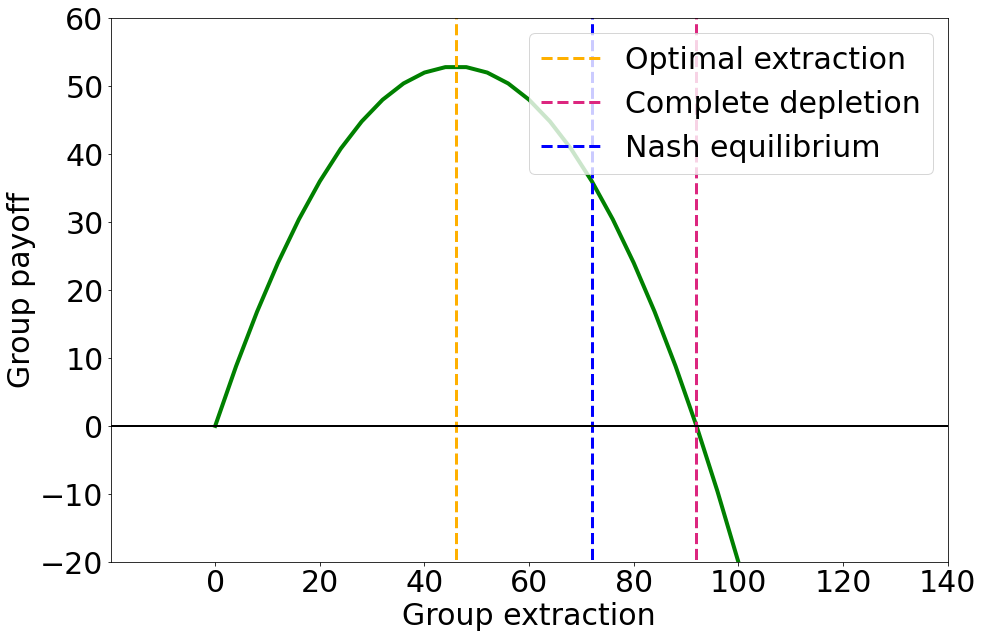

In [63]:
curve = []
for i in range(0, 104, 4):
    curve.append(payoff_extraction(i/4, i))
fig, ax = plt.subplots(figsize = (15, 10))#plt.figure(figsize = (15, 10))

ax.plot(curve, lw = 4, color = "green")
plt.ylim(-20, 60)
plt.xlim(-5, 35)
plt.vlines(11.5, -200, 600, linestyle = "dashed", color = treatment_palette["Pro-social"], lw = 3, label = "Optimal extraction")
plt.vlines(23, -200, 600, linestyle = "dashed", color = treatment_palette["Self-serving"], lw = 3, label = "Complete depletion")
plt.vlines(18, -200, 600, linestyle = "dashed", color = "blue", lw = 3, label = "Nash equilibrium")
plt.hlines(0, -5, 35, linestyle = "solid", color = "black", lw = 2)
plt.xticks(ticks=plt.xticks()[0][1:], labels=4 * np.array(plt.xticks()[0][1:], dtype=np.int64))
plt.ylabel("Group payoff")
plt.legend(loc = "upper right")
plt.xlabel("Group extraction")
plt.savefig('./images/source/cpr_group_extraction.svg', format='svg', dpi=300)

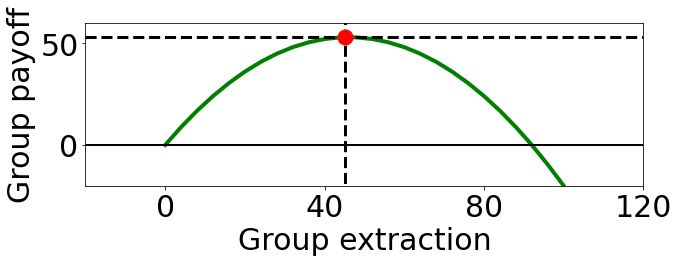

In [64]:
curve = []
for i in range(0, 104, 4):
    curve.append(payoff_extraction(i/4, i))
fig, ax = plt.subplots(figsize = (10, 3))


ax.plot(curve, lw = 4, color = "green")
plt.ylim(-20, 60)
plt.xlim(-5, 30)
plt.vlines(11.25, -200, 600, linestyle = "dashed", color = "black", lw = 3)
plt.hlines(52.87, -5, 35, linestyle = "dashed", color = "black", lw = 3)
plt.hlines(0, -5, 35, linestyle = "solid", color = "black", lw = 2)
plt.plot(11.25,52.87, "o", color = "red", markersize = 15)
plt.xticks(ticks=plt.xticks()[0][1:], labels=4 * np.array(plt.xticks()[0][1:], dtype=np.int64))
plt.ylabel("Group payoff")
plt.xlabel("Group extraction")
plt.savefig('./images/source/cpr_example.svg', format='svg', dpi=300)

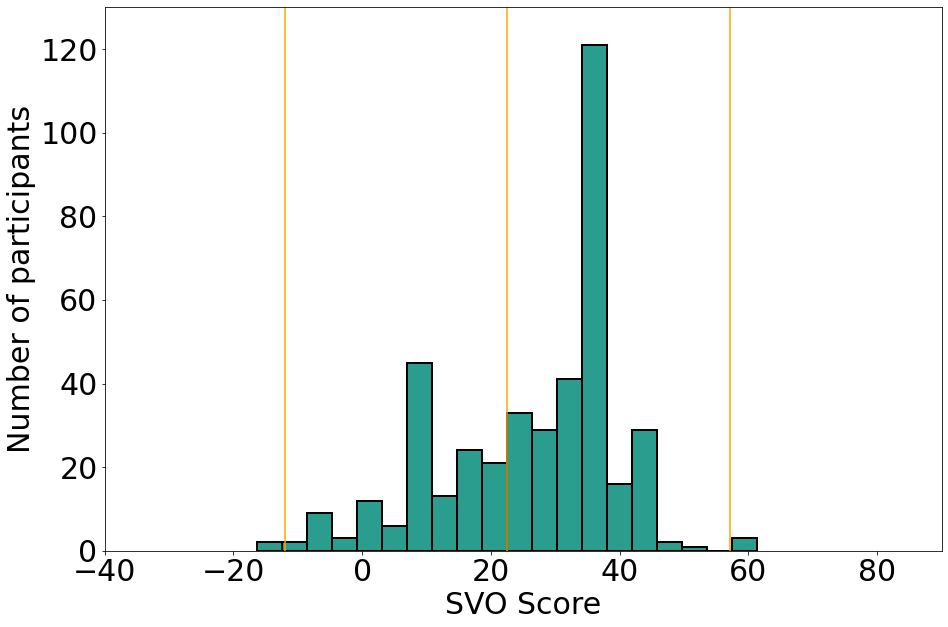

In [67]:
plt.figure(figsize = (15,10))
plt.hist(complete.svo_score, bins = 20, color = "#2a9d8f", lw = 2, edgecolor = "black")
plt.vlines(22.45, 0, 130, color = "orange")
plt.vlines(57.15, 0, 130, color = "orange")
plt.vlines(-12.04, 0, 130, color = "orange")
plt.xlim(-40, 90)
plt.ylim(0,130)
plt.xlabel("SVO Score")
plt.ylabel("Number of participants")
#plt.annotate('Individualistic', xy =(-3, 90))
#plt.annotate('Pro-social', xy =(35, 90))
#plt.annotate('Altruistic', xy =(68, 90))
plt.savefig('./images/source/svo_hist.svg', format='svg', dpi=300)

/Users/eladiomontero/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



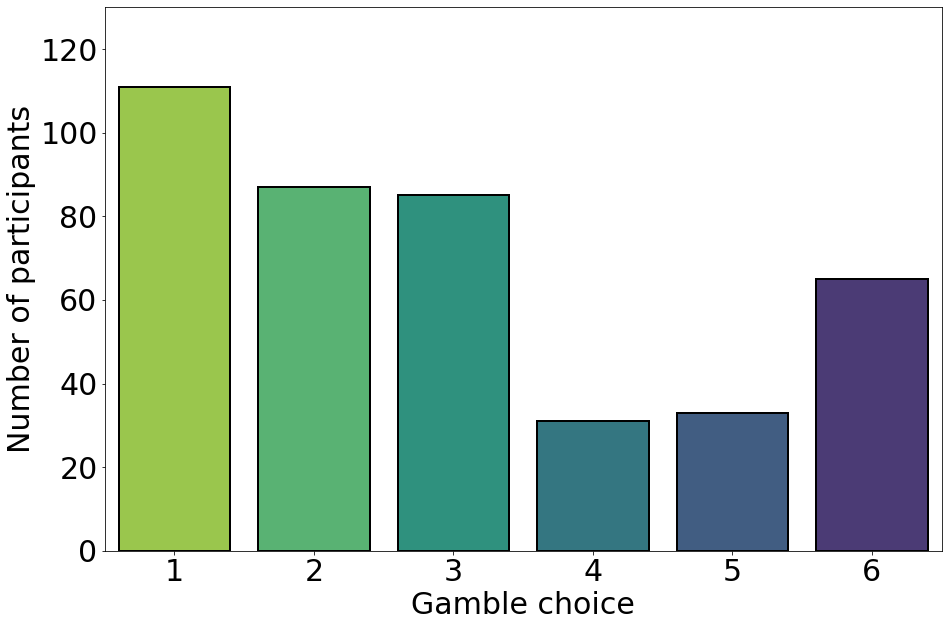

In [68]:
plt.figure(figsize = (15,10))
g = sns.countplot(complete["gamble_choice"], palette = "viridis_r", edgecolor = "black", lw = 2)
plt.xlabel("Gamble choice")
plt.ylabel("Number of participants")
g.set_xticklabels(range(1, 7))
#plt.annotate('Less risk', xy =(0, 110))
#plt.annotate('More risk', xy =(4, 110))
plt.ylim(0, 130)
plt.savefig('./images/source/gamble_dist.svg', format='svg', dpi=300)

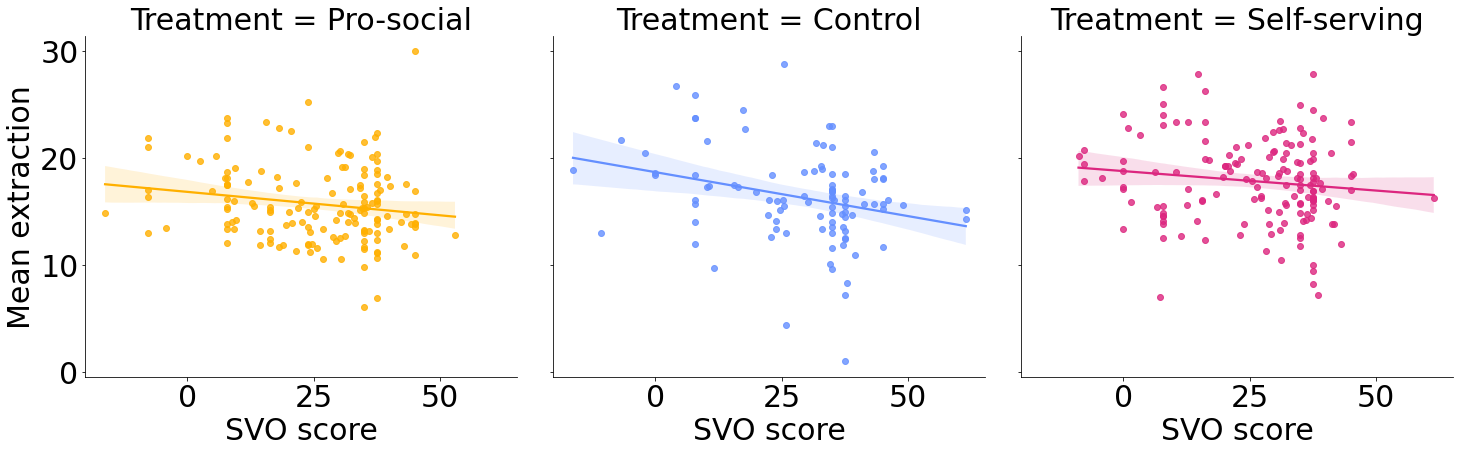

In [70]:
g = sns.FacetGrid(data = complete, col="Treatment", height = 7, hue = "Treatment", palette = treatment_palette, col_order = ["Pro-social", "Control", "Self-serving"])
g.map(sns.regplot, "svo_score", "mean_extraction")
for i in range(0, 3):
    g.axes[0, i].set_xlabel('SVO score')
g.axes[0,0].set_ylabel("Mean extraction")
plt.savefig('./images/source/svo_extraction.svg', format='svg', dpi=300)

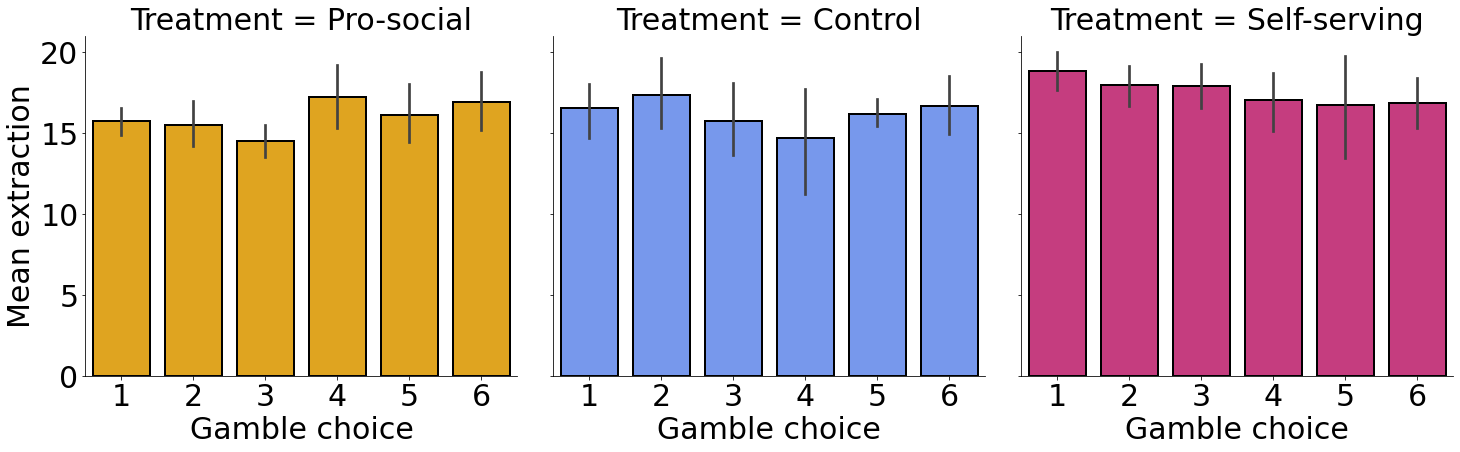

In [71]:
g = sns.FacetGrid(data = complete, col="Treatment", height = 7, hue = "Treatment", palette = treatment_palette, col_order = ["Pro-social", "Control", "Self-serving"])
g.map(sns.barplot, "gamble_choice", "mean_extraction", order = [1,2,3,4,5,6], edgecolor = "black", lw = 2)
for i in range(0, 3):
    g.axes[0, i].set_xlabel('Gamble choice')
g.axes[0,0].set_ylabel("Mean extraction")
plt.savefig('./images/source/gamble_extraction.svg', format='svg', dpi=300)

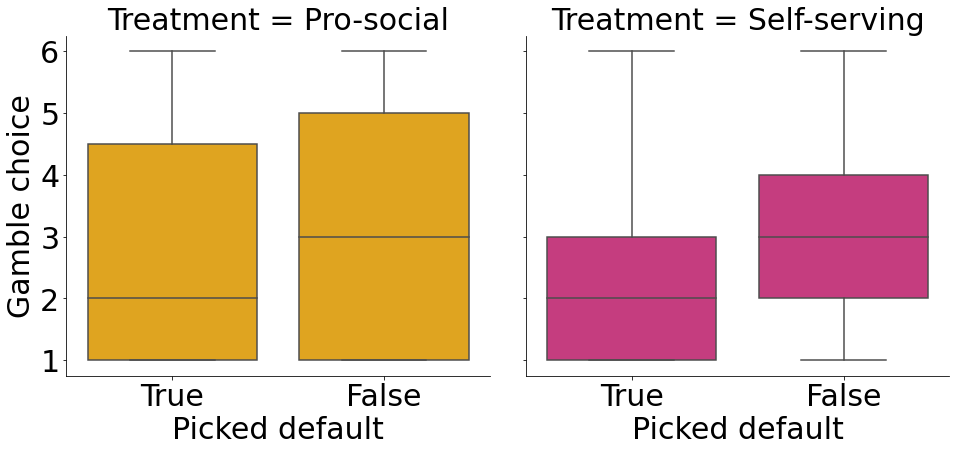

In [72]:
g = sns.catplot(data = data.loc[(data.Treatment.isin(["Pro-social", "Self-serving"]) & (data["round"] <= 5))], x = "picked_default", y = "gamble_choice", kind = "box", 
            col_order = ["Pro-social", "Self-serving"], order = [True, False], col = "Treatment", hue = "Treatment", hue_order = ["Pro-social", "Self-serving"],
            height = 7, palette = treatment_palette, dodge = False)
for i in range(0, 2):
    g.axes[0, i].set_xlabel('Picked default')
g.axes[0, 0].set_yticks([1,2,3,4,5,6])
g.axes[0, 0].set_ylabel('Gamble choice')
plt.savefig('./images/source/gamble_default.svg', format='svg', dpi=300)